<a href="https://www.kaggle.com/code/joshuacurtiswebb/simuledge?scriptVersionId=141681517" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from spx_strategies import *

#########################
# VERSION
#########################
notebook_name = 'simuledge'
notebook_v=0

#########################
# DATA CONFIGURATION
#########################
load_cboe = False
load_tradier = True

#########################
# STUDY CONFIGURATION
#########################
op_sel = DeltaOptionSelector
ent_pol_study = OptionSelectorStaticEntryPolicy
ex_pol_study = HoldToExpStaticExitPolicy
study_param_ranges = {
    'sp':(0.005,0.45),
    'lp':(0.002,''),
    'sc':(0.005,0.45),
    'lc':(0.002,''),
}

configs_ent_pol = {    
    'dte':1,
    'pt':'16:00:00'}

configs_ex_pol ={
}

configs_strat ={
    'comm':1.5,
    'ipv': 0.2
}
configs_strat['ds'] = 'tradier' if load_tradier else 'cboe'

configs = {}

# IPV will be overwritten when data is loaded
initial_portfolio_value = 1


num_trials = 5


In [2]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/simuledge/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)


Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-26-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-07-31-20.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-13-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-14-22.db
Copying db file to output : optimal-short-ic-study_2023-2023_1DTE_2023-08-23-22.db
Copying db file to output : DOS_OSSEntryP_sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier230714_230831_spx_st_0_simuledge_0.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-01-15.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-17-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-12-22.db
Copying db file to output : optimal-short-straddle-study_2023-2023_1DTE_2023-08-08-23.db
Copying db file to output : 

In [3]:
def ipv_transform(df, scaling_factor):
    if 'price' not in df.columns:
        raise Exception("Need 'price' in dataframe")
        
    return df.loc[1,'price']*scaling_factor*100


In [4]:
if load_cboe:

    files = [
    #     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
    #     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
    #    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
        #f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv",
       # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1545_1600.csv"
       # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
     #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1545_1600.csv"
      #  f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2018_1545_1600.csv"
       # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2017_1545_1600.csv"
      # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2016_1545_1600.csv"
       f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2019_1dte_all.csv",
        f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_1dte_all.csv",
        f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1dte_all.csv",
        f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1dte_all.csv"
    ]
    li = []
    for f in files:   
        df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
        li.append(df)

    df = pd.concat(li, axis=0, ignore_index=True)
    df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
    df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
    df['delta'] = df['delta'].abs()

    if 'dte' not in df:
        raise Exception("dte must be present")

    df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
    df_ty['Date'] = pd.to_datetime(df_ty['Date'])
    
    df_irx = df_ty

In [5]:
if load_tradier:
    for dirname, _, filenames in os.walk('/kaggle/input/spx-option-chain-1dte-all-times'):
        for f in filenames:
            if 'spx' in f:
                df = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df.rename(columns={'underlying':'price'},inplace=True)
                df.drop(columns=['Unnamed: 0'], inplace=True)
                df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
                df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
                df['delta'] = df['delta'].abs()
            elif 'irx' in f:
                df_irx = pd.read_csv(os.path.join(dirname, f), index_col=None, header=0)
                df_irx.rename(columns={'close':'Adj Close','quote_date':'Date'},inplace=True)
                df_irx['Adj Close']*= 100
                df_irx['Date']=pd.to_datetime(df_irx['Date'],infer_datetime_format=True)
                df_irx['quote_time']=pd.to_datetime(df_irx['quote_time'],infer_datetime_format=True)
                df_irx = df_irx.loc[df_irx.groupby('Date')['quote_time'].idxmax()]
                df_irx.drop(columns=['Unnamed: 0', 'quote_time'], inplace=True)


In [6]:
# For whatever data we've loaded, create an initial portfolio value
initial_portfolio_value = ipv_transform(df, configs_strat['ipv'])

# Backtest Optimization

In [7]:
# purchase_time = '16:01:00'
# dos = DeltaOptionSelector(short_puts=0.04, short_calls=0.02)
# # dos = YieldOptionSelector(short_puts=0.0006, short_calls=0.0003, ipv=initial_portfolio_value)
# ent_pol=OptionSelectorStaticEntryPolicy(1, purchase_time, dos)
# #ex_pol = HoldToExpStaticExitPolicy('16:00:00')
# ex_pol = MaxLossDynamicExitPolicy(1.5)
# strat = StaticEntryDynamicExitStrategy(commission, df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
# strat.evaluate(df)


In [8]:
def run_backtest(strat, df):
    return strat.evaluate(df)['Cumulative Return']

In [9]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float('sp', study_param_ranges['sp'][0], study_param_ranges['sp'][1])
    delta_lp_trial = trial.suggest_float('lp', study_param_ranges['lp'][0], delta_sp_trial)
    delta_sc_trial = trial.suggest_float('sc', study_param_ranges['sc'][0], study_param_ranges['sc'][1])
    delta_lc_trial = trial.suggest_float('lc', study_param_ranges['lc'][0], delta_sc_trial)
   
    dos = op_sel(short_puts=delta_sp_trial, long_puts=delta_lp_trial,short_calls=delta_sc_trial, long_calls=delta_lc_trial)
    ent_pol=ent_pol_study(configs_ent_pol['dte'], configs_ent_pol['pt'], dos)
    
    ex_pol = ex_pol_study()

    strategy = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=False)
    score = run_backtest(strategy, df)
    return score

In [10]:
study_name = get_study_name(op_sel, ent_pol_study, study_param_ranges, 
                   configs_ent_pol, ex_pol_study, configs_ex_pol,
                   configs_strat, configs, df, spx_strat_v,
                   notebook_name, notebook_v
                  )
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, configs_ent_pol['pt']), n_trials = num_trials)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-09-01 20:21:51,017] A new study created in RDB with name: DOS_OSSEntryP__sp_0.005_0.45_lp_0.002__sc_0.005_0.45_lc_0.002__dte_1_pt_16:00:00_HTESExitP_comm_1.5_ipv_0.2_ds_tradier_230714_230831_spx_st_0_simuledge_0
[I 2023-09-01 20:21:53,271] Trial 0 finished with value: -0.089 and parameters: {'sp': 0.35045358602438414, 'lp': 0.27175555303817917, 'sc': 0.4232360524700182, 'lc': 0.17509414358828557}. Best is trial 0 with value: -0.089.
[I 2023-09-01 20:21:55,439] Trial 1 finished with value: -0.482 and parameters: {'sp': 0.1358670922617303, 'lp': 0.0818880177648622, 'sc': 0.060521826194368834, 'lc': 0.012069845468989662}. Best is trial 0 with value: -0.089.
[I 2023-09-01 20:21:57,603] Trial 2 finished with value: -2.79 and parameters: {'sp': 0.39356659725486187, 'lp': 0.27774912453384903, 'sc': 0.131905918030063, 'lc': 0.08907612671389142}. Best is trial 0 with value: -0.089.
[I 2023-09-01 20:21:59,768] Trial 3 finished with value: -0.074 and parameters: {'sp': 0.19830618289866261

Best Score:  -0.074
Best Params: 
  lc: 0.13897588014718296
  lp: 0.012600227247663567
  sc: 0.2150836991118242
  sp: 0.19830618289866261


# Backtest with current best score

*****  BACKTEST RESULTS  ****
Cumulative Return                                -0.074
Max Drawdown                                     -2.201
Mean Net Max Loss                              9727.279
Max Net Max Loss                                17490.0
Mean Return on Max Risk                          -0.001
Std Dev of Return on Max Risk                     0.122
Risk Adj Cumulative Return On Scaled Max Risk    -0.607
Trading Days                                         34
Wins                                                 24
Losses                                               10
Breakeven                                             0
Win/Loss Ratio                                   70.588
Mean Win                                        458.125
Mean Loss                                       -887.95
Mean Net Trans                                   62.221
Std Dev of Net Trans                            854.186
Max Loss                                        -3377.5
Max Win           

,trade_date,expiration,trade_count,strike_sp_0,strike_sc_0,strike_lc_0,strike_lp_0,delta_sp_target_0,delta_sp_0,collected_sp_0,delta_sc_target_0,delta_sc_0,collected_sc_0,delta_lc_target_0,delta_lc_0,collected_lc_0,delta_lp_target_0,delta_lp_0,collected_lp_0,collected,lost_c,lost_p,price,commission,lost,net,portfolio_value,net_cumsum,transaction_return,cum_return,daily_risk_free_return,gross_max_loss,net_max_loss,return_on_max_risk,scaled_return_on_max_risk
0,2023-07-14,2023-07-17,4.0,4480.0,4525.0,4535.0,4365.0,0.198306,0.178156,257.5,0.215084,0.212605,305.0,0.138976,0.114801,-140.0,0.0126,0.012437,-30.0,392.5,169.0,0.0,4526.69,6.0,169.0,217.5,90418.3,217.5,NaN,0.002411,0.000207,11500.0,11107.5,0.019581,1.000392
1,2023-07-17,2023-07-18,4.0,4500.0,4545.0,4555.0,4395.0,0.198306,0.165757,250.0,0.215084,0.203932,240.0,0.138976,0.102093,-105.0,0.0126,0.012054,-25.0,360.0,1000.0,0.0,4558.32,6.0,1000.0,-646.0,89772.3,-428.5,-0.007145,-0.004751,0.000208,10500.0,10140.0,-0.063708,0.998726
2,2023-07-18,2023-07-19,4.0,4535.0,4580.0,4590.0,4420.0,0.198306,0.192177,295.0,0.215084,0.185865,235.0,0.138976,0.100680,-117.5,0.0126,0.012487,-30.0,382.5,0.0,0.0,4568.48,6.0,0.0,376.5,90148.8,-52.0,0.004194,-0.000576,0.000208,11500.0,11117.5,0.033866,1.000677
3,2023-07-19,2023-07-20,4.0,4540.0,4595.0,4605.0,4425.0,0.198306,0.166846,270.0,0.215084,0.192951,312.5,0.138976,0.111529,-160.0,0.0126,0.012130,-30.0,392.5,0.0,599.0,4534.01,6.0,599.0,-212.5,89936.3,-264.5,-0.002357,-0.002932,0.000208,11500.0,11107.5,-0.019131,0.999617
4,2023-07-20,2023-07-21,4.0,4510.0,4560.0,4570.0,4375.0,0.198306,0.177861,257.5,0.215084,0.199779,330.0,0.138976,0.120051,-175.0,0.0126,0.012576,-35.0,377.5,0.0,0.0,4537.79,6.0,0.0,371.5,90307.8,107.0,0.004131,0.001186,0.000208,13500.0,13122.5,0.028310,1.000566
5,2023-07-21,2023-07-24,4.0,4510.0,4560.0,4570.0,4440.0,0.198306,0.153185,232.5,0.215084,0.195514,250.0,0.138976,0.108001,-125.0,0.0126,0.011173,-20.0,337.5,0.0,0.0,4552.82,6.0,0.0,331.5,90639.3,438.5,0.003671,0.004861,0.000208,7000.0,6662.5,0.049756,1.000995
6,2023-07-24,2023-07-25,4.0,4530.0,4575.0,4585.0,4465.0,0.198306,0.169521,225.0,0.215084,0.204215,295.0,0.138976,0.107855,-130.0,0.0126,0.012285,-20.0,370.0,0.0,0.0,4571.38,6.0,0.0,364.0,91003.3,802.5,0.004016,0.008897,0.000208,6500.0,6130.0,0.059380,1.001188
7,2023-07-25,2023-07-26,4.0,4530.0,4610.0,4620.0,4440.0,0.198306,0.187364,495.0,0.215084,0.183649,415.0,0.138976,0.125181,-257.5,0.0126,0.011699,-25.0,627.5,0.0,0.0,4566.59,6.0,0.0,621.5,91624.8,1424.0,0.006829,0.015787,0.000209,9000.0,8372.5,0.074231,1.001485
8,2023-07-26,2023-07-27,4.0,4540.0,4595.0,4600.0,4445.0,0.198306,0.167403,252.5,0.215084,0.176236,280.0,0.138976,0.131333,-190.0,0.0126,0.012438,-25.0,317.5,0.0,623.0,4533.77,6.0,623.0,-311.5,91313.3,1112.5,-0.003400,0.012334,0.000209,9500.0,9182.5,-0.033923,0.999322
9,2023-07-27,2023-07-28,4.0,4495.0,4570.0,4580.0,4315.0,0.198306,0.173930,400.0,0.215084,0.190843,417.5,0.138976,0.130258,-262.5,0.0126,0.012482,-45.0,510.0,872.0,0.0,4578.72,6.0,872.0,-368.0,90945.3,744.5,-0.004030,0.008254,0.000209,18000.0,17490.0,-0.021041,0.999579


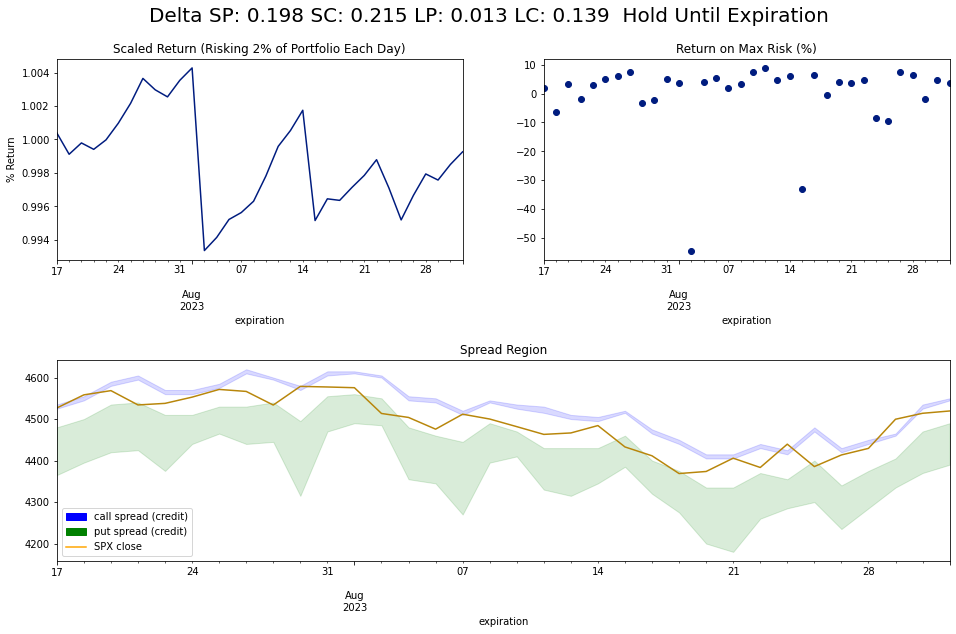

In [11]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, configs_ent_pol['pt'], dos)
ex_pol = HoldToExpStaticExitPolicy()
strat = StaticEntryStaticExitStrategy(configs_strat['comm'], df_irx, initial_portfolio_value, ent_pol, ex_pol, debug=True)
strat.evaluate(df)

strat.df_trades

# Strikes for tomorrow with current best

In [12]:
next_exp = df['expiration'].max()
quote_date_next_exp = df[(df['expiration']==df['expiration'].max())&(df['quote_date']!=df['expiration'].max())]['quote_date'].iloc[0]
df_trades = pd.DataFrame([{'trade_date':quote_date_next_exp,'expiration':next_exp}])
df_filt = df[
    (df['expiration']==df['expiration'].max())&
    (df['quote_date']!=df['expiration'].max())&
    (df['quote_time']=='16:00:00')
]

In [13]:
dos = DeltaOptionSelector(short_puts=trial.params['sp'],short_calls=trial.params['sc'], long_puts=trial.params['lp'],long_calls=trial.params['lc'])
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2023-08-31,2023-09-01,0.198306,4480.0,0.164731,365.0,0.215084,4545.0,0.172233,237.5,0.138976,4550.0,0.129879,-170.0,0.0126,4395.0,0.011408,-25.0,4,407.5


# Strikes following the 4/2 Strategy

In [14]:
dos = DeltaOptionSelector(short_puts=0.04,short_calls=0.02)
ent_pol=OptionSelectorStaticEntryPolicy(1, '16:01:00', dos)
dos.populateTrades(df_filt,df_trades,ent_pol.get_contract_strike)

,trade_date,expiration,delta_sp_target_0,strike_sp_0,delta_sp_0,collected_sp_0,delta_sc_target_0,strike_sc_0,delta_sc_0,collected_sc_0,delta_lc_target_0,strike_lc_0,delta_lc_0,collected_lc_0,delta_lp_target_0,strike_lp_0,delta_lp_0,collected_lp_0,trade_count,collected
0,2023-08-31,2023-09-01,0.04,4445.0,0.037433,62.5,0.02,4585.0,0.016634,15.0,0.138976,4550.0,0.129879,-170.0,0.0126,4395.0,0.011408,-25.0,4,-117.5
